# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [ ]:
# @TODO: extract tags?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


from utils import *
from dataset import *
from plots import *

## Load data

Let's load the metadata and the images.

In [3]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [4]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

12:55:05 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR82_IM-2350-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [5]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis.

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been scaled to 256x256. 

In [6]:
N = 1500
np_images = load_images(metadata[:N], IMAGE_PATH, resized=(256, 256))
images = torch.tensor(np_images)

There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since it hasn't already been annotated, we will ignore it for now.

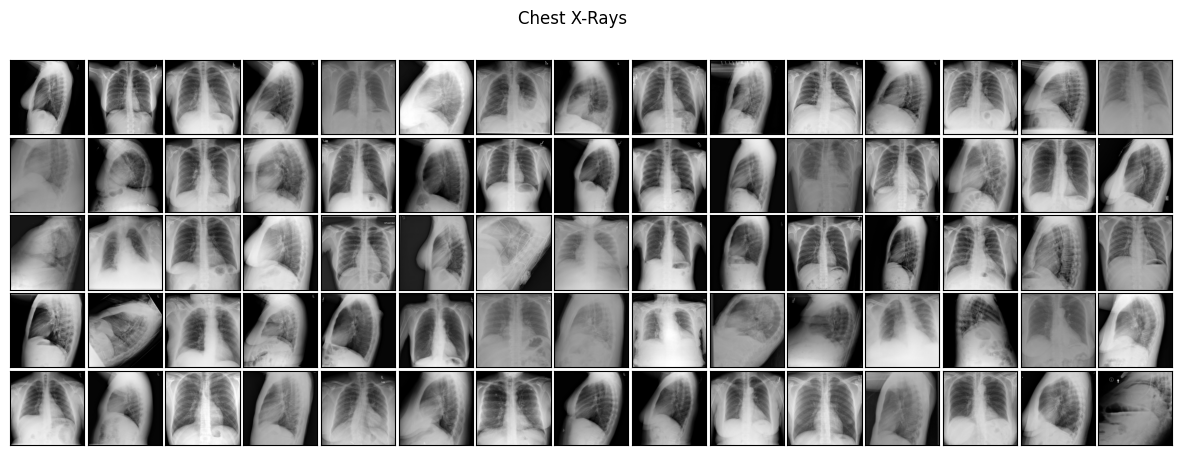

In [7]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

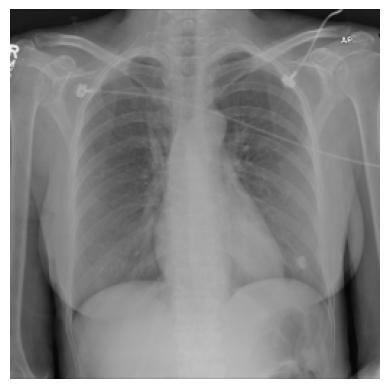

In [8]:
highlighted_sample = metadata.loc[metadata["image_name"] == "CXR21_IM-0729-1001-0001.png"]
highlighted_image = images[highlighted_sample.index]

plot_image(highlighted_image[0])

Time to plot a random X-ray image and its corresponding findings!

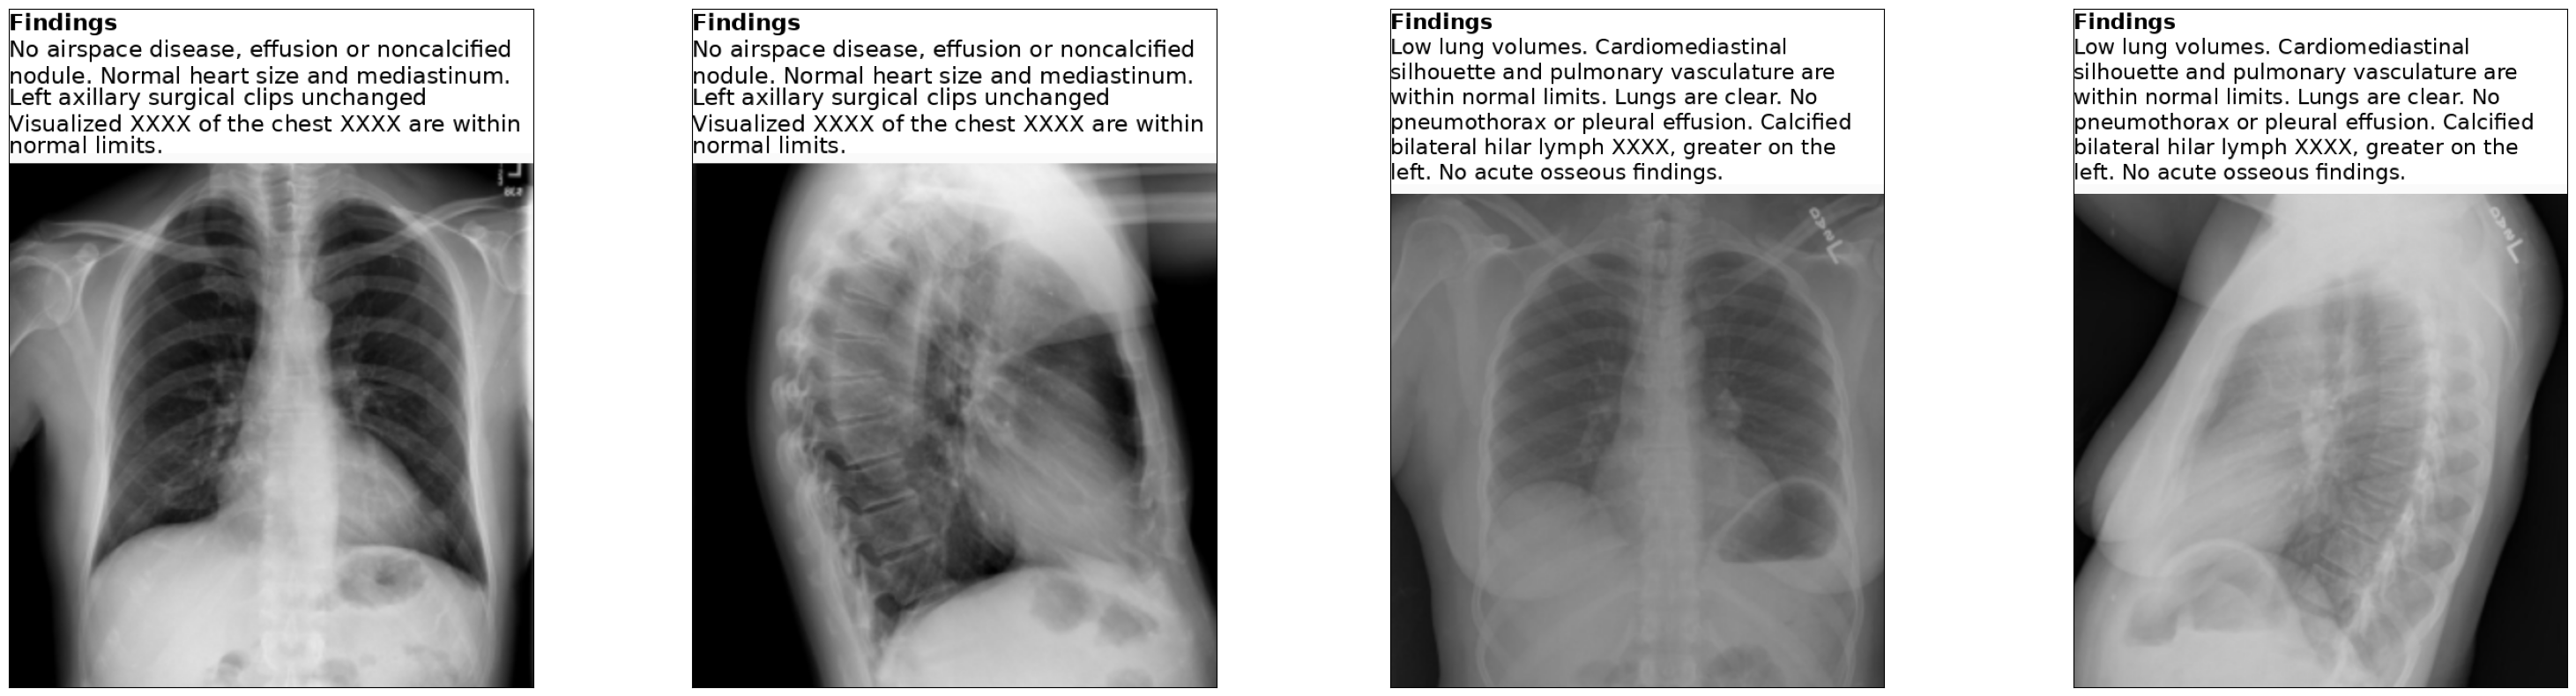

In [14]:
k = range(4)

title = "Findings"
extracted_textbodies = metadata.iloc[k]["findings"]
extracted_images = np_images[k]

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

In [11]:
# reference: https://arxiv.org/pdf/1711.08195v3.pdf
# @TODO: tokenization, embedding
# @TODO: transformer model

### Images

Let's, normalize the images to the range [0, 1].

In [12]:
images = images.type(torch.float32) / 255.

In [18]:
images.shape

torch.Size([1500, 256, 256, 3])

### Text